# Utterance Similarity Visualization Using Pretrained Language Models

This notebook explores the similarity between utterances from different age groups in the BNC2014 corpus. We'll use a pretrained language model to encode utterances and visualize their similarity across age groups.

Key steps:
1. Load the BNC2014 corpus data and speaker metadata
2. Extract utterances for each age group
3. Create balanced samples across age groups
4. Encode utterances using a pretrained language model (e.g., BERT, Sentence-BERT)
5. Calculate cosine similarity between utterance embeddings
6. Visualize the similarity patterns using dimensionality reduction (t-SNE, UMAP)
7. Cluster the utterances and analyze the most common tokens in each cluster
8. Report on whether the clusters accurately reflect age groups

In [8]:
# Import required libraries
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import lxml.etree as ET
from tqdm.auto import tqdm
import random
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
import torch
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

# For reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download NLTK data if not already present
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    
# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

Using device: cuda


## 1. Load and Prepare BNC2014 Data

First, we'll load the speaker metadata and corpus data from the BNC2014 dataset.

Loaded metadata for 671 speakers

Sample of speaker metadata:
      exactage  age1994 agerange gender      nat  \
S0001       32    25_34    30_39      F  British   
S0002      NaN  Unknown    19_29      F  British   
S0003      NaN  Unknown    19_29      F  British   
S0004      NaN  Unknown    30_39      M  British   
S0005      NaN   60plus    80_89      F  British   

                               birthplace birthcountry       l1 lingorig  \
S0001             Wordsley, West Midlands      England  English  England   
S0002                          Birmingham      England  English  England   
S0003  Royal Leamington Spa, Warwickshire      England  English  England   
S0004                                 NaN      Germany  English  England   
S0005                          Birmingham      England  English  England   

          dialect_rep  ...   dialect_l2   dialect_l3   dialect_l4  \
S0001  None indicated  ...  unspecified  unspecified  unspecified   
S0002        Midlands  ...    

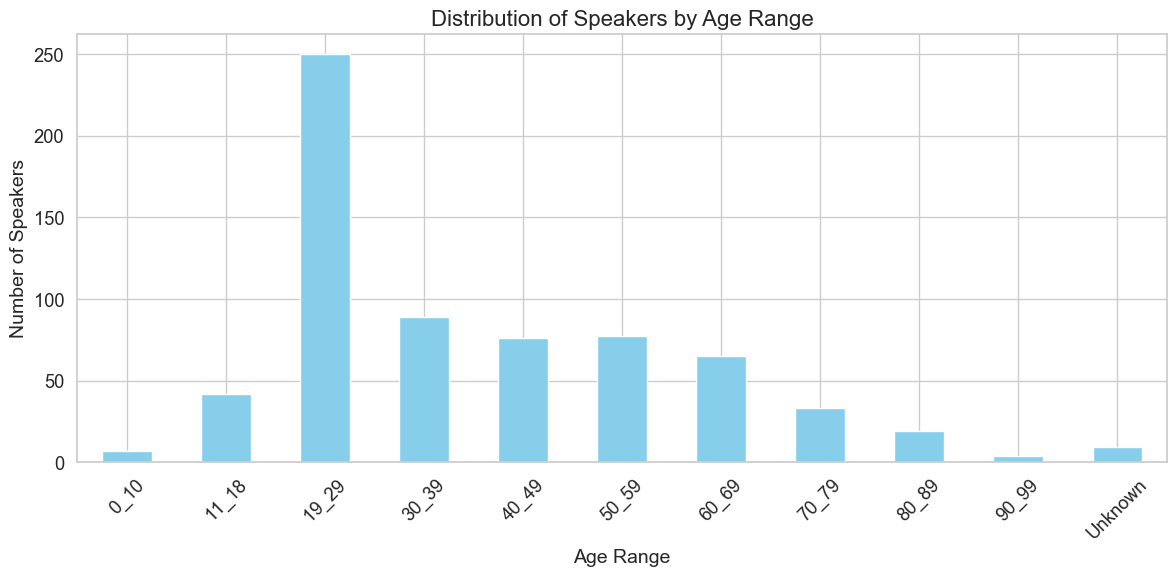

In [9]:
# Set the path to the dataset
path = 'Dataset'  
dir_corpus = os.path.join(path, 'spoken', 'tagged')
dir_meta = os.path.join(path, 'spoken', 'metadata')

# Load speaker metadata
fields_s = pd.read_csv(
    os.path.join(dir_meta, 'metadata-fields-speaker.txt'),
    sep='\t', skiprows=1, index_col=0
)

# Load the speaker metadata
df_speakers_meta = pd.read_csv(
    os.path.join(dir_meta, 'bnc2014spoken-speakerdata.tsv'),
    sep='\t', names=fields_s['XML tag'], index_col=0
)

print(f"Loaded metadata for {len(df_speakers_meta)} speakers")
print("\nSample of speaker metadata:")
print(df_speakers_meta.head())

# Check the distribution of age ranges in the metadata
print("\nAge range distribution:")
age_counts = df_speakers_meta['agerange'].value_counts().sort_index()
print(age_counts)

# Visualize age distribution
plt.figure(figsize=(12, 6))
age_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Speakers by Age Range', fontsize=16)
plt.xlabel('Age Range', fontsize=14)
plt.ylabel('Number of Speakers', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Define Age Groups and Extract Utterances

We'll define our age groups and extract utterances for each speaker. To ensure a balanced analysis, we'll create age groups with roughly equal numbers of speakers or use balanced sampling.

Distribution of speakers by age group:
age_group
Young Adult    250
Middle-aged    242
Senior         121
Child           49
Name: count, dtype: int64


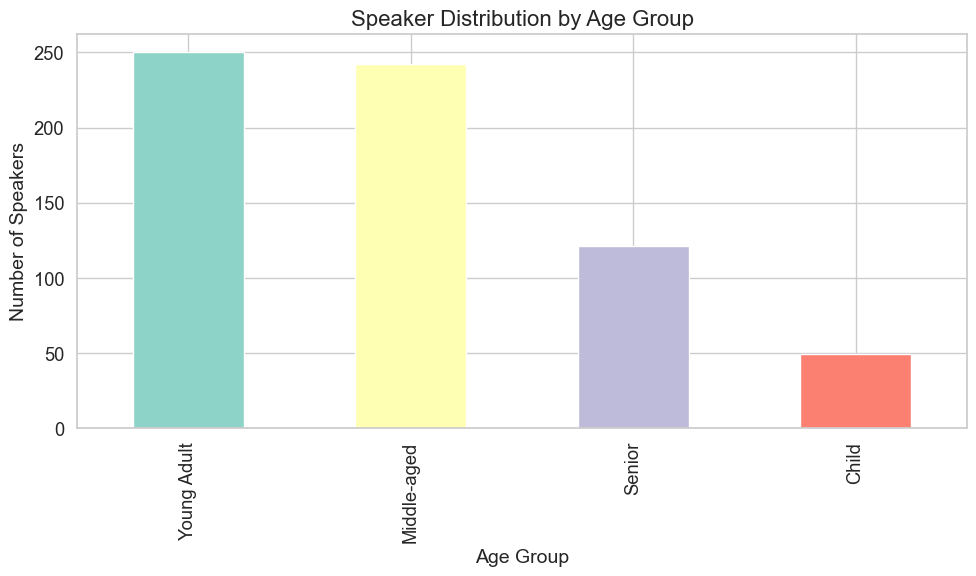

In [30]:
# Define four balanced age groups for more nuanced analysis
def map_to_four_age_groups(age_range):
    """
    Map age ranges from BNC metadata to four standard age groups.
    
    Parameters:
    -----------
    age_range : str
        Age range from BNC metadata (e.g., '0_10', '11_18', '19_29', etc.)
        
    Returns:
    --------
    str
        Age group classification
    """
    if pd.isna(age_range) or age_range == 'Unknown':
        return np.nan
    
    try:
        # Map age ranges to four groups based on actual data
        if age_range in ['0_10', '11_18']:
            return "Child"
        elif age_range in ['19_29']:
            return "Young Adult"
        elif age_range in ['30_39', '40_49', '50_59']:
            return "Middle-aged"
        elif age_range in ['60_69', '70_79', '80_89', '90_99']:
            return "Senior"
        else:
            return np.nan
    except Exception as e:
        # Return np.nan for any errors
        print(f"Error in mapping age range '{age_range}': {e}")
        return np.nan

# Apply the age group mapping to the speaker metadata
df_speakers_meta['age_group'] = df_speakers_meta['agerange'].apply(map_to_four_age_groups)

# Display the counts for each age group
age_group_counts = df_speakers_meta['age_group'].value_counts()
print("Distribution of speakers by age group:")
print(age_group_counts)

# Check if we have data before plotting
if len(age_group_counts) > 0:
    # Create a bar chart to visualize the distribution
    plt.figure(figsize=(10, 6))
    
    # Use a color palette that adapts to the number of groups
    color_palette = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072']
    # Make sure we have enough colors for all groups
    colors = color_palette[:len(age_group_counts)]
    
    age_group_counts.plot(kind='bar', color=colors)
    plt.title('Speaker Distribution by Age Group', fontsize=16)
    plt.xlabel('Age Group', fontsize=14)
    plt.ylabel('Number of Speakers', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No age group data to plot. Check if the age groups were correctly assigned.")

In [12]:
# Extract utterances from the corpus
# We'll use a limited number of files to keep processing time reasonable
file_limit = 200  # Adjust based on your computational resources

print("Extracting utterances from corpus files...")

# Store utterances with speaker information
utterances_data = []

# Process corpus files to extract utterances
try:
    # Check if directory exists
    if not os.path.exists(dir_corpus):
        raise FileNotFoundError(f"Corpus directory not found: {dir_corpus}")
    
    # Get list of files in corpus directory
    corpus_files = sorted(os.listdir(dir_corpus))
    if not corpus_files:
        raise FileNotFoundError(f"No files found in corpus directory: {dir_corpus}")
    
    # Use only the first file_limit files
    files_to_process = corpus_files[:file_limit]
    
    # Load a subset of corpus files
    for file_count, fname in enumerate(files_to_process):
        if file_count % 20 == 0:
            print(f"Processing file {file_count+1}/{len(files_to_process)}: {fname}")
            
        try:
            fpath = os.path.join(dir_corpus, fname)
            xml = ET.parse(fpath)
            root = xml.getroot()
            text_id = root.get('id')
            
            for u in root.findall('.//u'):
                utt_id = u.get('n')
                spk_id = u.get('who')
                
                # Skip utterances without a speaker ID
                if not spk_id or spk_id not in df_speakers_meta.index:
                    continue
                
                # Get the speaker's age group
                age_group = df_speakers_meta.loc[spk_id, 'age_group']
                
                # Skip if age group is unknown
                if pd.isna(age_group):
                    continue
                
                # Extract all words in the utterance
                words = []
                for w in u.findall('.//w'):
                    if w.text:
                        words.append(w.text)
                
                # Only include utterances with at least 5 words
                if len(words) >= 5:
                    utterance_text = ' '.join(words)
                    
                    # Clean the utterance text
                    utterance_text = re.sub(r'\s+', ' ', utterance_text).strip()
                    
                    utterances_data.append({
                        'text_id': text_id,
                        'utterance_id': utt_id,
                        'speaker_id': spk_id,
                        'age_group': age_group,
                        'utterance': utterance_text,
                        'word_count': len(words)
                    })
        
        except Exception as file_error:
            print(f"Error processing file {fname}: {file_error}")
            continue  # Skip this file and continue with the next
    
    # Create a DataFrame from the extracted data
    df_utterances = pd.DataFrame(utterances_data)
    
    print(f"\nExtracted {len(df_utterances)} utterances from {len(files_to_process)} files")
    print(f"Utterances by age group:")
    print(df_utterances['age_group'].value_counts())
    
    # Check if we have enough data to proceed
    if len(df_utterances) < 10:
        raise ValueError("Not enough utterances extracted to proceed with analysis")
    
except Exception as e:
    print(f"Error loading corpus data: {e}")
    raise RuntimeError(f"Failed to extract utterances: {e}")

Extracting utterances from corpus files...
Processing file 1/200: S23A-tgd.xml
Processing file 21/200: S2FT-tgd.xml
Processing file 41/200: S2UT-tgd.xml
Processing file 21/200: S2FT-tgd.xml
Processing file 41/200: S2UT-tgd.xml
Processing file 61/200: S37K-tgd.xml
Processing file 61/200: S37K-tgd.xml
Processing file 81/200: S3MW-tgd.xml
Processing file 81/200: S3MW-tgd.xml
Processing file 101/200: S457-tgd.xml
Processing file 101/200: S457-tgd.xml
Processing file 121/200: S4MV-tgd.xml
Processing file 121/200: S4MV-tgd.xml
Processing file 141/200: S555-tgd.xml
Processing file 141/200: S555-tgd.xml
Processing file 161/200: S5MM-tgd.xml
Processing file 161/200: S5MM-tgd.xml
Processing file 181/200: S64H-tgd.xml
Processing file 181/200: S64H-tgd.xml

Extracted 111739 utterances from 200 files
Utterances by age group:
age_group
Middle-aged    41620
Young Adult    40087
Senior         17845
Child          12187
Name: count, dtype: int64

Extracted 111739 utterances from 200 files
Utterances b

In [13]:
# Inspect the unique values in the 'agerange' column
print("Unique values in the 'agerange' column:")
print(df_speakers_meta['agerange'].unique())

# Count occurrences of each value
print("\nCounts of each value:")
print(df_speakers_meta['agerange'].value_counts(dropna=False))

Unique values in the 'agerange' column:
['30_39' '19_29' '80_89' '60_69' '70_79' '40_49' '50_59' '90_99' '11_18'
 '0_10' 'Unknown']

Counts of each value:
agerange
19_29      250
30_39       89
50_59       77
40_49       76
60_69       65
11_18       42
70_79       33
80_89       19
Unknown      9
0_10         7
90_99        4
Name: count, dtype: int64


In [14]:
# Fix the map_to_four_age_groups function to match the actual age range values
def map_to_four_age_groups_fixed(age_range):
    """
    Map age ranges from BNC metadata to four standard age groups.
    
    Parameters:
    -----------
    age_range : str
        Age range from BNC metadata (e.g., '0_10', '11_18', '19_29', etc.)
        
    Returns:
    --------
    str
        Age group classification
    """
    if pd.isna(age_range) or age_range == 'Unknown':
        return np.nan
    
    try:
        # Map age ranges to four groups based on actual data
        if age_range in ['0_10', '11_18']:
            return "Child"
        elif age_range in ['19_29']:
            return "Young Adult"
        elif age_range in ['30_39', '40_49', '50_59']:
            return "Middle-aged"
        elif age_range in ['60_69', '70_79', '80_89', '90_99']:
            return "Senior"
        else:
            return np.nan
    except Exception as e:
        # Return np.nan for any errors
        print(f"Error in mapping age range '{age_range}': {e}")
        return np.nan

# Apply the fixed mapping function
df_speakers_meta['age_group'] = df_speakers_meta['agerange'].apply(map_to_four_age_groups_fixed)

# Display the counts for each age group after fixing
age_group_counts = df_speakers_meta['age_group'].value_counts()
print("\nFixed distribution of speakers by age group:")
print(age_group_counts)


Fixed distribution of speakers by age group:
age_group
Young Adult    250
Middle-aged    242
Senior         121
Child           49
Name: count, dtype: int64


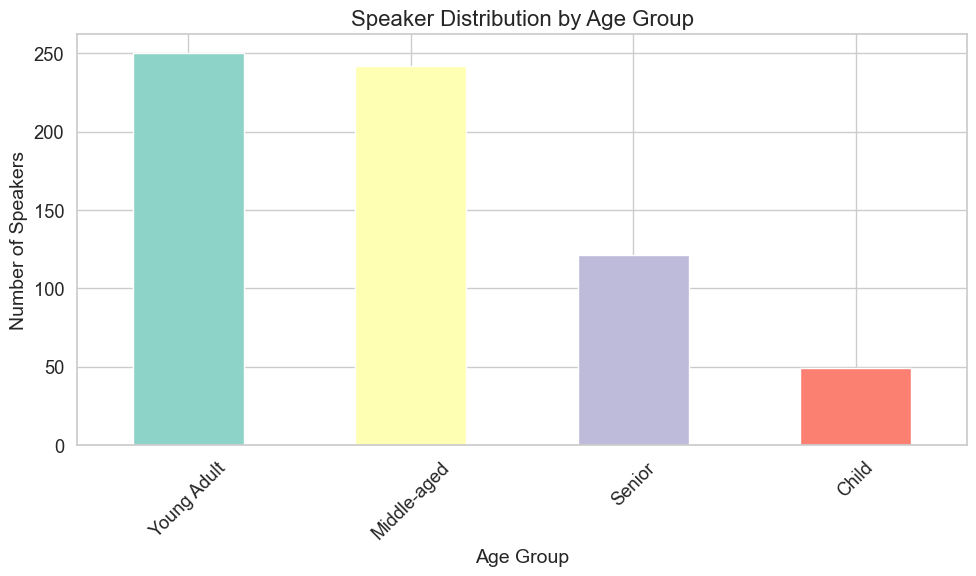

In [15]:
# Visualize the fixed age group distribution
plt.figure(figsize=(10, 6))

# Use a color palette that adapts to the number of groups
color_palette = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072']
# Make sure we have enough colors for all groups
colors = color_palette[:len(age_group_counts)]

age_group_counts.plot(kind='bar', color=colors)
plt.title('Speaker Distribution by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Number of Speakers', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Create Balanced Samples

To ensure fair comparison, we'll create balanced samples from each age group.

In [16]:
# Create balanced samples from each age group
# Find the minimum count across age groups
min_count = df_utterances['age_group'].value_counts().min()
print(f"Minimum utterance count across age groups: {min_count}")

# Determine a reasonable sample size (adjust as needed)
sample_size = min(min_count, 1000)  # Cap at 1000 utterances per age group to manage computational load

# Sample utterances from each age group
balanced_utterances = []
for age_group in df_utterances['age_group'].unique():
    group_utterances = df_utterances[df_utterances['age_group'] == age_group]
    
    # Filter to include only utterances with reasonable length (5-50 words)
    filtered_utterances = group_utterances[
        (group_utterances['word_count'] >= 5) & 
        (group_utterances['word_count'] <= 50)
    ]
    
    # Randomly sample from the filtered utterances
    if len(filtered_utterances) > sample_size:
        sampled = filtered_utterances.sample(sample_size, random_state=RANDOM_SEED)
    else:
        sampled = filtered_utterances
    
    balanced_utterances.append(sampled)

# Combine the balanced samples
df_balanced = pd.concat(balanced_utterances, ignore_index=True)
print(f"Created balanced dataset with {len(df_balanced)} utterances")
print("Utterances per age group in balanced dataset:")
print(df_balanced['age_group'].value_counts())

# Display sample utterances from each age group
print("\nSample utterances from each age group:")
for age_group in df_balanced['age_group'].unique():
    sample_utts = df_balanced[df_balanced['age_group'] == age_group].sample(3, random_state=RANDOM_SEED)
    print(f"\n{age_group}:")
    for i, (_, row) in enumerate(sample_utts.iterrows(), 1):
        print(f"  {i}. \"{row['utterance']}\" (Speaker ID: {row['speaker_id']})")

Minimum utterance count across age groups: 12187
Created balanced dataset with 4000 utterances
Utterances per age group in balanced dataset:
age_group
Middle-aged    1000
Young Adult    1000
Child          1000
Senior         1000
Name: count, dtype: int64

Sample utterances from each age group:

Middle-aged:
  1. "yeah okay and any particular anything ? or just what what I think 's nice" (Speaker ID: S0255)
  2. "I still say Shaggy did it myself" (Speaker ID: S0094)
  3. "I 'm happy and it literally was about three different channels" (Speaker ID: S0257)

Young Adult:
  1. "--UNCLEARWORD cos I 'm always around it cos a lot of my mates --UNCLEARWORD" (Speaker ID: S0203)
  2. "so like as the ti- as the game goes on you take off tiles so the island or" (Speaker ID: S0021)
  3. "I yeah is it him looking up at you ?" (Speaker ID: S0439)

Child:
  1. "oh I I do n't want to chop it up sorry" (Speaker ID: S0416)
  2. "like it 's literally just a Fren-" (Speaker ID: S0324)
  3. "it 's it 's no

## 4. Encode Utterances Using a Pretrained Language Model

We'll use a pretrained language model to encode our utterances. For this task, Sentence-BERT is a good choice as it's specifically designed to create semantically meaningful sentence embeddings.

In [ ]:
# Install sentence-transformers if not already available
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    print("Installing sentence-transformers...")
    %pip install --quiet sentence-transformers
    try:
        from sentence_transformers import SentenceTransformer
    except ImportError:
        raise ImportError("Could not install sentence-transformers. Please install it manually with 'pip install sentence-transformers'")

# Load a pretrained Sentence-BERT model
print("Loading pretrained model...")
model_name = 'all-MiniLM-L6-v2'  # Smaller and faster model, good for initial exploration


try:
    model = SentenceTransformer(model_name)
    model.to(device)
    print(f"Loaded model: {model_name}")

    # Encode utterances in batches to avoid memory issues
    batch_size = 32
    print(f"Encoding {len(df_balanced)} utterances...")

    # Create a list of all utterances
    utterances = df_balanced['utterance'].tolist()

    # Encode in batches
    embeddings = []
    for i in tqdm(range(0, len(utterances), batch_size)):
        batch = utterances[i:i+batch_size]
        batch_embeddings = model.encode(batch, convert_to_tensor=True, show_progress_bar=False)
        embeddings.append(batch_embeddings.cpu().numpy())

    # Combine all batches
    embeddings = np.vstack(embeddings)
    print(f"Created embeddings with shape: {embeddings.shape}")

    # Add embeddings to the DataFrame (as separate columns)
    embedding_df = pd.DataFrame(
        embeddings, 
        columns=[f'dim_{i}' for i in range(embeddings.shape[1])]
    )
    df_balanced_with_embeddings = pd.concat([df_balanced.reset_index(drop=True), embedding_df], axis=1)
except Exception as e:
    print(f"Error loading model or creating embeddings: {e}")
    raise RuntimeError(f"Model loading failed: {e}")

Loading pretrained model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Loaded model: all-MiniLM-L6-v2
Encoding 4000 utterances...


100%|██████████| 125/125 [00:04<00:00, 28.81it/s]

Created embeddings with shape: (4000, 384)


## 5. Dimensionality Reduction and Visualization

To visualize the high-dimensional embeddings, we'll use t-SNE (t-distributed Stochastic Neighbor Embedding) to reduce dimensionality to 2D or 3D.

Applying t-SNE for dimensionality reduction...


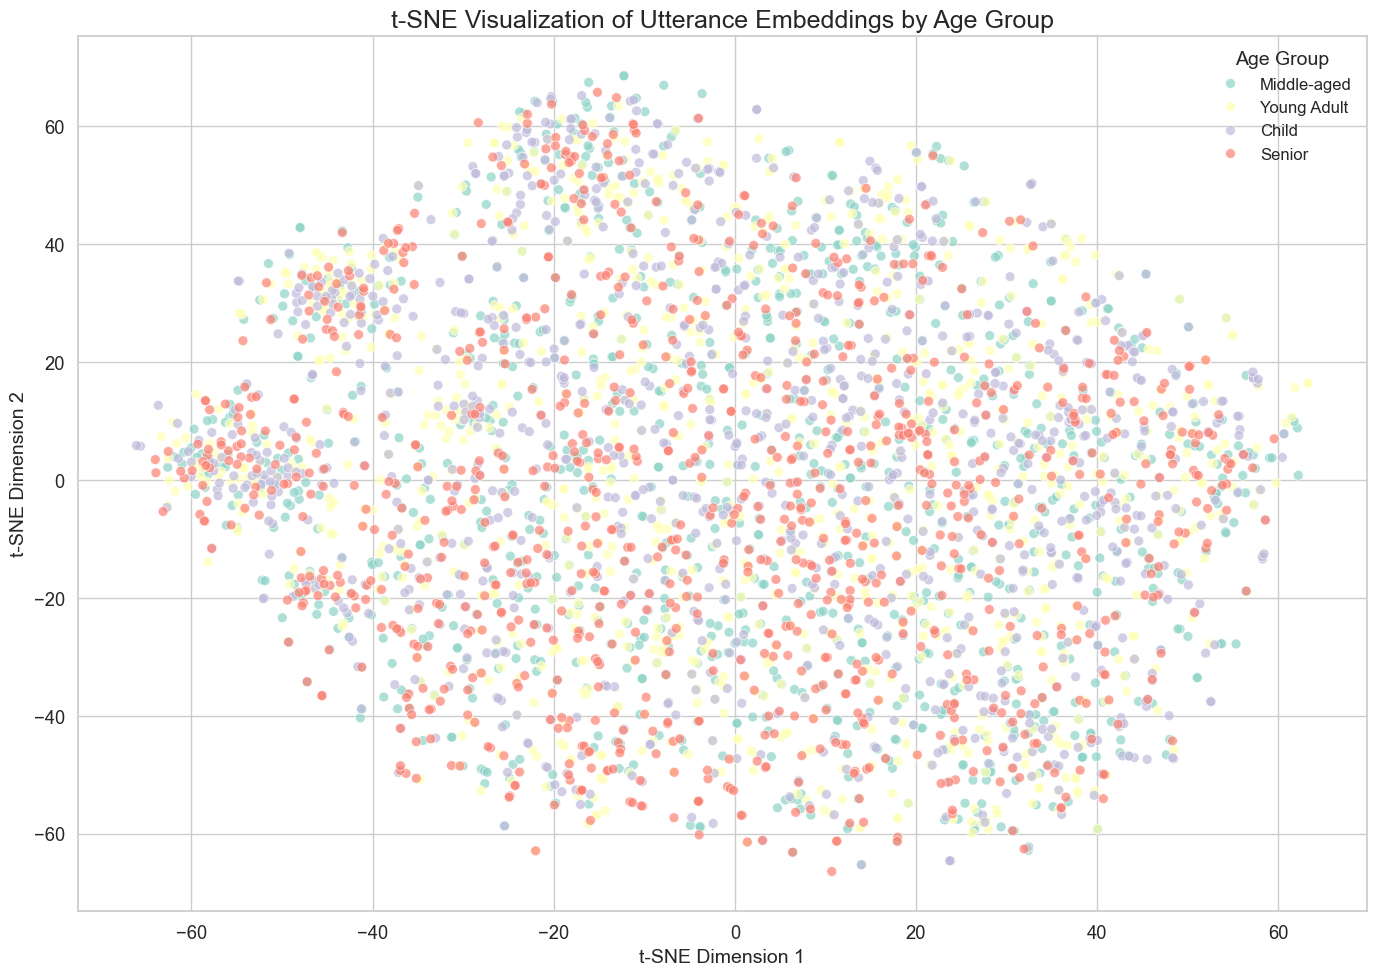

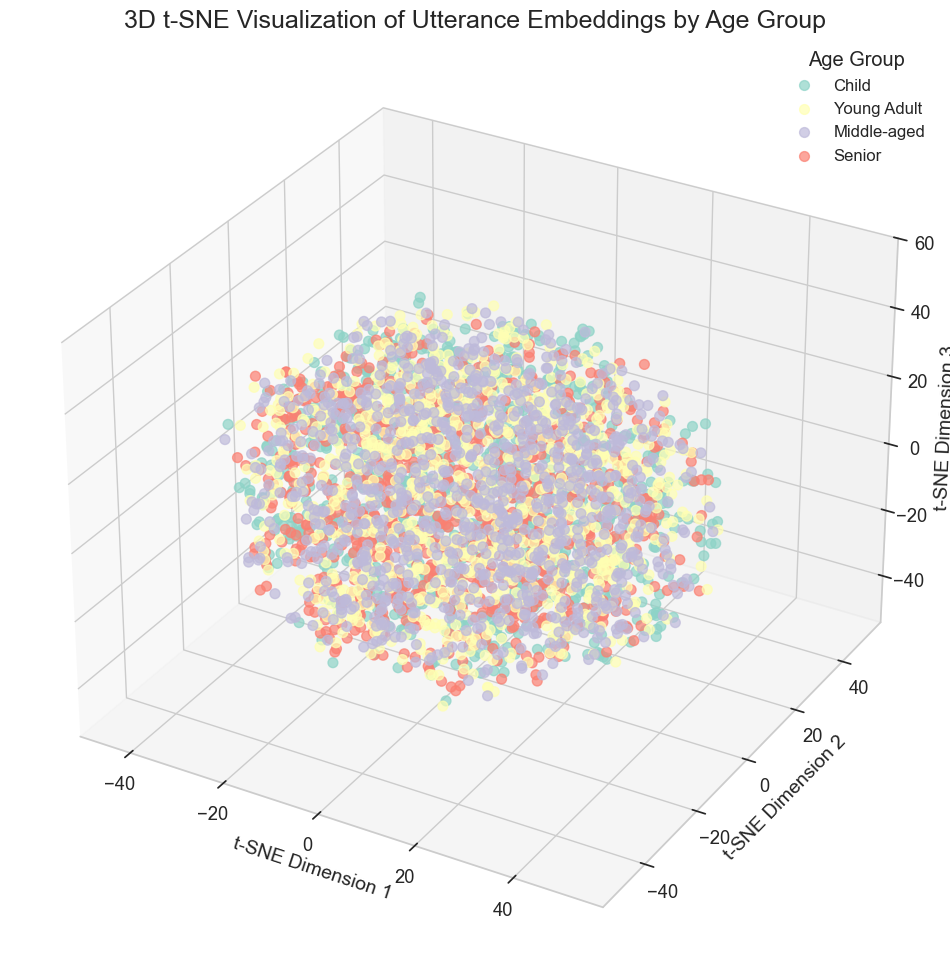

In [18]:
# Apply t-SNE to reduce dimensionality for visualization
print("Applying t-SNE for dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)

# Create a DataFrame with the 2D coordinates and age group
viz_df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'age_group': df_balanced['age_group'].values,
    'utterance': df_balanced['utterance'].values,
    'speaker_id': df_balanced['speaker_id'].values
})

# Create a scatter plot colored by age group
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=viz_df, x='x', y='y', hue='age_group', 
    palette=['#8dd3c7', '#ffffb3', '#bebada', '#fb8072'],
    alpha=0.7, s=50
)

plt.title('t-SNE Visualization of Utterance Embeddings by Age Group', fontsize=18)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)
plt.legend(title='Age Group', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

# Also create a 3D visualization for more detail
try:
    # Import 3D plotting tools with proper error handling
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    
    # Apply t-SNE to get 3D embeddings
    tsne_3d = TSNE(n_components=3, random_state=RANDOM_SEED, perplexity=30, n_iter=1000)
    embeddings_3d = tsne_3d.fit_transform(embeddings)
    
    # Create a DataFrame with the 3D coordinates and age group
    viz_df_3d = pd.DataFrame({
        'x': embeddings_3d[:, 0],
        'y': embeddings_3d[:, 1],
        'z': embeddings_3d[:, 2],
        'age_group': df_balanced['age_group'].values
    })
    
    # Create a 3D scatter plot
    fig = plt.figure(figsize=(14, 10))
    # Create 3D axes explicitly setting the projection
    ax = fig.add_subplot(111, projection='3d')
    
    # Define colors for each age group
    colors = {'Child': '#8dd3c7', 'Young Adult': '#ffffb3', 'Middle-aged': '#bebada', 'Senior': '#fb8072'}
    
    # Plot each age group separately
    for age_group, color in colors.items():
        group_data = viz_df_3d[viz_df_3d['age_group'] == age_group]
        if len(group_data) > 0:  # Only plot if we have data for this age group
            ax.scatter(
                group_data['x'], group_data['y'], group_data['z'],
                label=age_group, color=color, alpha=0.7, s=50
            )
    
    ax.set_title('3D t-SNE Visualization of Utterance Embeddings by Age Group', fontsize=18)
    ax.set_xlabel('t-SNE Dimension 1', fontsize=14)
    ax.set_ylabel('t-SNE Dimension 2', fontsize=14)
    ax.set_zlabel('t-SNE Dimension 3', fontsize=14)
    ax.legend(title='Age Group', fontsize=12)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create 3D visualization: {e}")
    print("Skipping 3D visualization and continuing with the analysis...")

## 6. Quantify Similarity Between Age Groups

We'll calculate the average cosine similarity between utterances from different age groups to measure linguistic distance quantitatively.

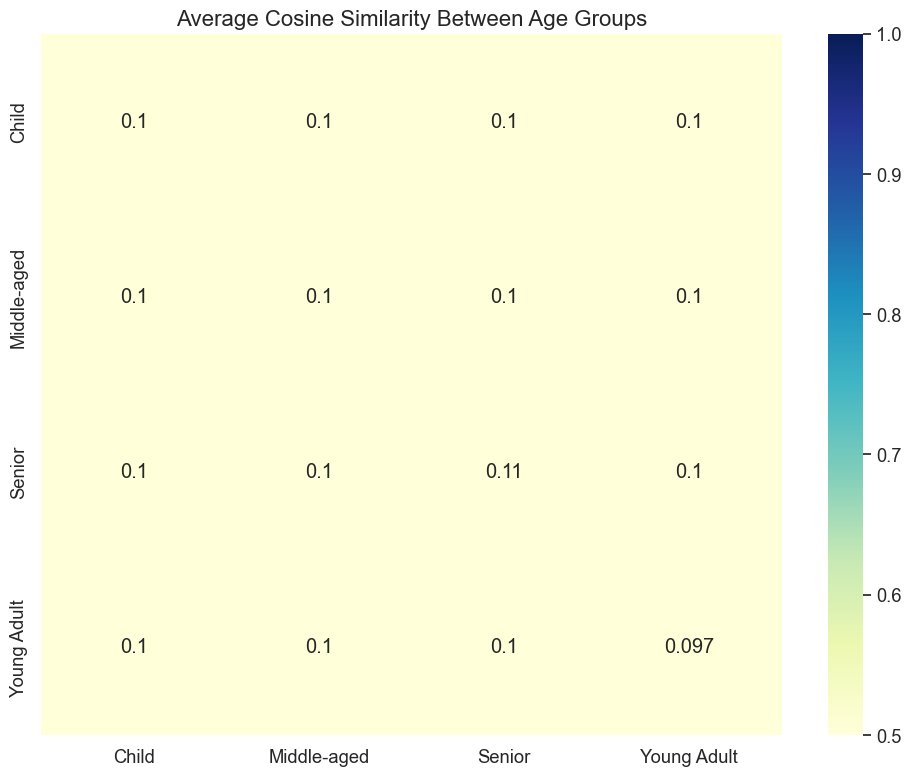

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate average similarity between and within age groups
age_groups = sorted(df_balanced['age_group'].unique())
num_groups = len(age_groups)

# Create a matrix to store average similarities
similarity_matrix = np.zeros((num_groups, num_groups))

# Create a dictionary mapping age group to indices
age_group_indices = {group: df_balanced[df_balanced['age_group'] == group].index for group in age_groups}

# Calculate pairwise similarities
for i, group1 in enumerate(age_groups):
    for j, group2 in enumerate(age_groups):
        # Get embeddings for each group
        group1_embeddings = embeddings[age_group_indices[group1]]
        group2_embeddings = embeddings[age_group_indices[group2]]
        
        # If comparing a group to itself, sample pairs to avoid excessive computation
        if group1 == group2 and len(group1_embeddings) > 100:
            # Sample 5000 random pairs (adjust as needed)
            max_pairs = 5000
            sampled_indices1 = np.random.choice(len(group1_embeddings), min(len(group1_embeddings), int(np.sqrt(max_pairs))), replace=False)
            sampled_indices2 = np.random.choice(len(group2_embeddings), min(len(group2_embeddings), int(np.sqrt(max_pairs))), replace=False)
            
            # Calculate similarities for sampled pairs
            similarities = []
            for idx1 in sampled_indices1:
                for idx2 in sampled_indices2:
                    if idx1 != idx2:  # Avoid comparing an utterance to itself
                        sim = cosine_similarity([group1_embeddings[idx1]], [group2_embeddings[idx2]])[0][0]
                        similarities.append(sim)
            
            avg_sim = np.mean(similarities) if similarities else 0
        else:
            # Calculate full pairwise similarity matrix
            sim_matrix = cosine_similarity(group1_embeddings, group2_embeddings)
            
            # If comparing a group to itself, exclude the diagonal (self-similarity)
            if group1 == group2:
                np.fill_diagonal(sim_matrix, 0)
                avg_sim = sim_matrix.sum() / (sim_matrix.size - len(sim_matrix))
            else:
                avg_sim = sim_matrix.mean()
        
        similarity_matrix[i, j] = avg_sim

# Visualize the similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    similarity_matrix, 
    annot=True, 
    cmap='YlGnBu', 
    xticklabels=age_groups,
    yticklabels=age_groups,
    vmin=0.5,  # Adjust these values based on your results
    vmax=1.0
)
plt.title('Average Cosine Similarity Between Age Groups', fontsize=16)
plt.tight_layout()
plt.show()

## 7. Cluster the Embeddings

We'll apply clustering algorithms to the embeddings to see if they naturally group by age.

Determining optimal number of clusters...
For n_clusters = 2, the silhouette score is 0.017
For n_clusters = 2, the silhouette score is 0.017
For n_clusters = 3, the silhouette score is 0.017
For n_clusters = 3, the silhouette score is 0.017
For n_clusters = 4, the silhouette score is 0.016
For n_clusters = 4, the silhouette score is 0.016
For n_clusters = 5, the silhouette score is 0.018
For n_clusters = 5, the silhouette score is 0.018
For n_clusters = 6, the silhouette score is 0.021
For n_clusters = 6, the silhouette score is 0.021
For n_clusters = 7, the silhouette score is 0.023
For n_clusters = 7, the silhouette score is 0.023
For n_clusters = 8, the silhouette score is 0.025
For n_clusters = 8, the silhouette score is 0.025
For n_clusters = 9, the silhouette score is 0.027
For n_clusters = 9, the silhouette score is 0.027


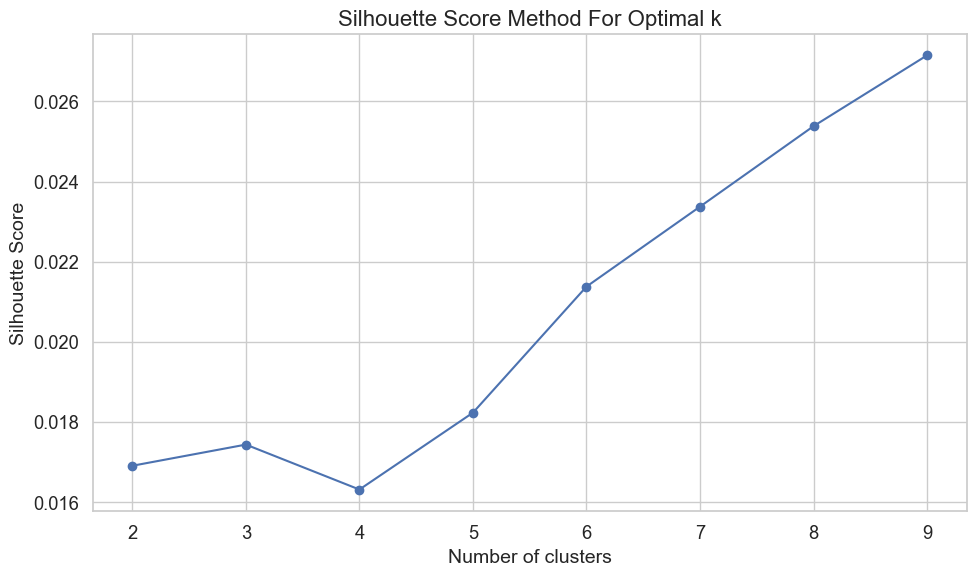

Optimal number of clusters: 4


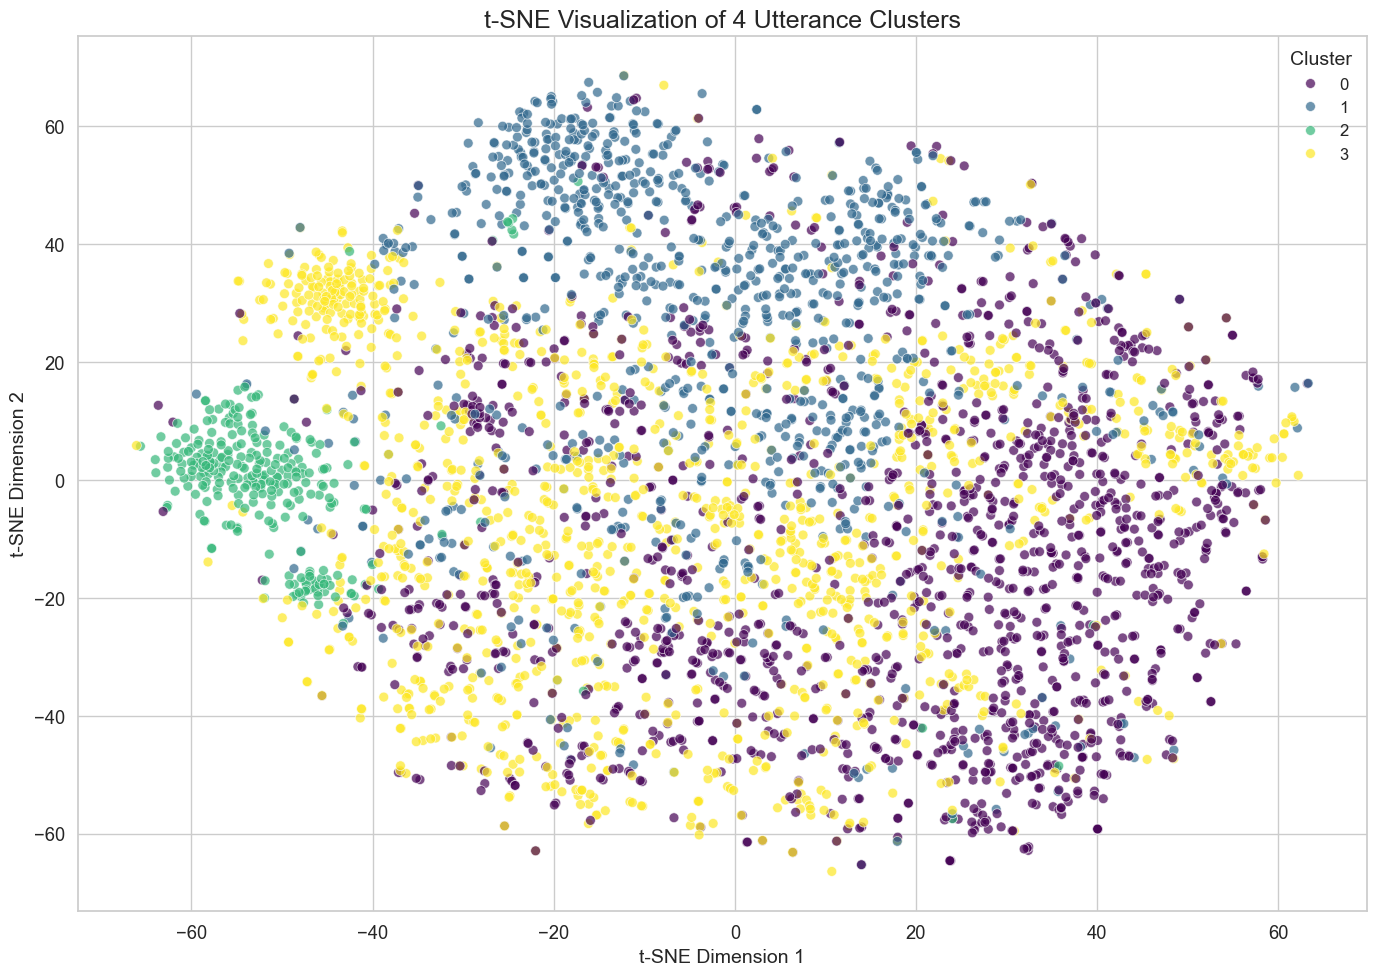

In [25]:
# Determine the optimal number of clusters using the silhouette method
from sklearn.metrics import silhouette_score

print("Determining optimal number of clusters...")
range_n_clusters = range(2, 10)
silhouette_scores = []

for n_clusters in range_n_clusters:
    # Initialize the clusterer
    # Use n_init parameter with explicit value to handle scikit-learn version differences
    # In scikit-learn 1.0+ warning appears if n_init='auto' is not used
    # In older versions, n_init=10 is the safe default
    try:
        clusterer = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED, n_init='auto')
    except TypeError:
        # Fall back to n_init=10 for older scikit-learn versions
        clusterer = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED, n_init=10)
    
    cluster_labels = clusterer.fit_predict(embeddings)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.3f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, 'o-', color='#4c72b0')
plt.xlabel('Number of clusters', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.title('Silhouette Score Method For Optimal k', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Select the optimal number of clusters based on silhouette score
optimal_clusters = 4
print(f"Optimal number of clusters: {optimal_clusters}")

# Apply KMeans with the optimal number of clusters
try:
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=RANDOM_SEED, n_init='auto')
except TypeError:
    # Fall back to n_init=10 for older scikit-learn versions
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=RANDOM_SEED, n_init=10)

clusters = kmeans.fit_predict(embeddings)

# Add cluster assignments to the visualization DataFrame
viz_df['cluster'] = clusters

# Plot the clusters with t-SNE visualization
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=viz_df, x='x', y='y', hue='cluster', 
    palette='viridis',
    alpha=0.7, s=50
)
plt.title(f't-SNE Visualization of {optimal_clusters} Utterance Clusters', fontsize=18)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)
plt.legend(title='Cluster', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

## 8. Analyze Cluster Composition by Age Group

Let's examine how the clusters align with age groups.

Cluster composition by age group (percentages):
age_group      Child  Middle-aged     Senior  Young Adult
cluster                                                  
0          26.406036    25.308642  21.262003    27.023320
1          24.660397    23.928945  25.809822    25.600836
2          27.272727    20.727273  28.000000    24.000000
3          23.206107    26.335878  27.938931    22.519084


<Figure size 1400x800 with 0 Axes>

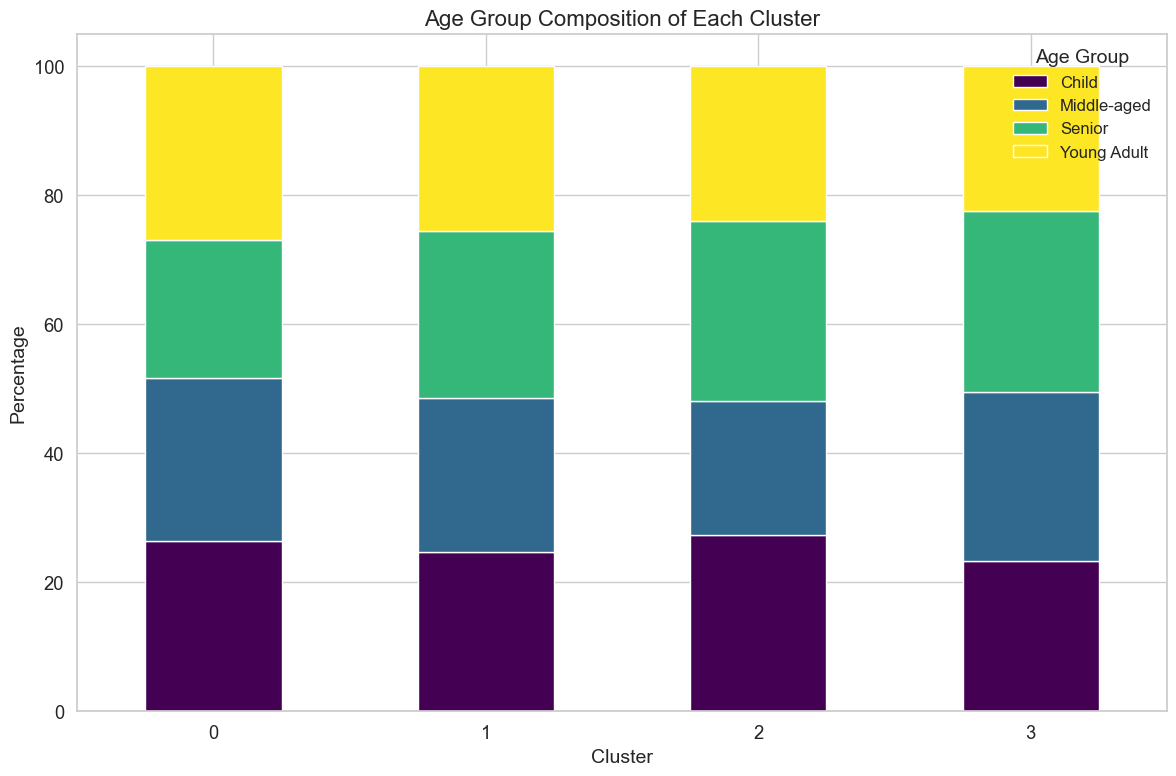

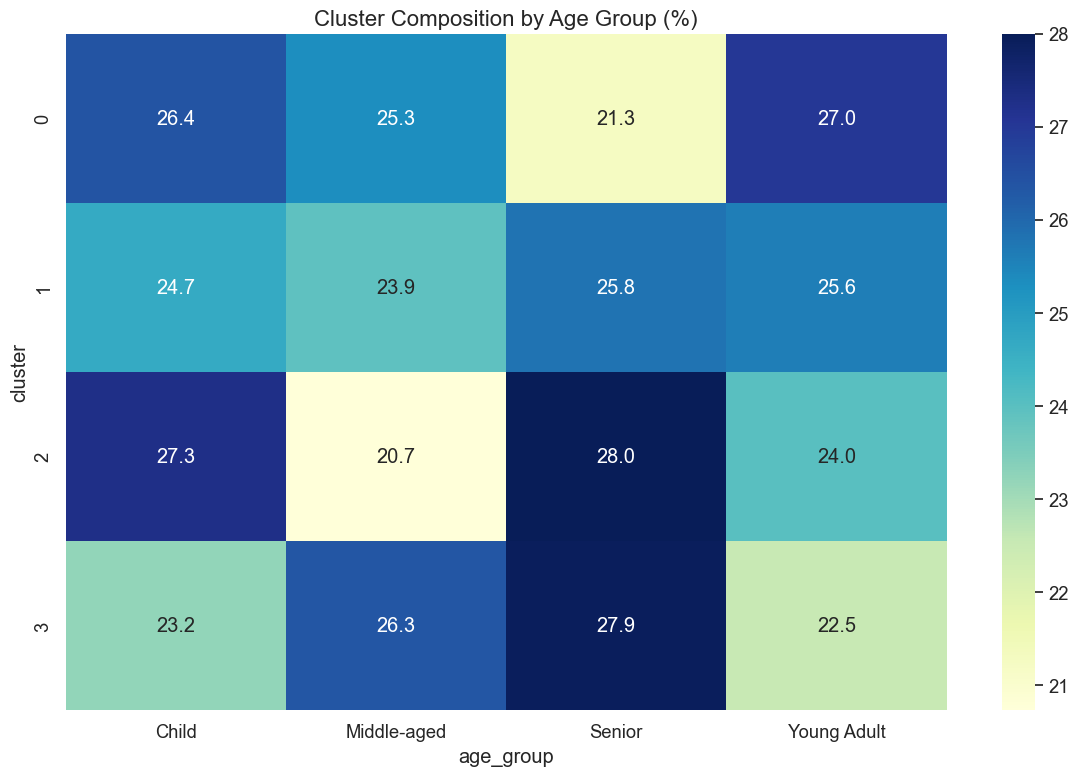

Homogeneity score: 0.0024
(A score of 1.0 means clusters contain only data points from the same age group)


In [26]:
# Add cluster assignments to the balanced DataFrame
df_balanced['cluster'] = clusters

# Create a cross-tabulation of clusters vs. age groups
cluster_age_crosstab = pd.crosstab(
    df_balanced['cluster'], 
    df_balanced['age_group'],
    normalize='index'  # Normalize by row (cluster)
) * 100  # Convert to percentages

print("Cluster composition by age group (percentages):")
print(cluster_age_crosstab)

# Visualize the cluster composition
plt.figure(figsize=(14, 8))
cluster_age_crosstab.plot(
    kind='bar', 
    stacked=True,
    colormap='viridis'
)
plt.title('Age Group Composition of Each Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Age Group', fontsize=12, title_fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Create a heatmap for better visualization
plt.figure(figsize=(12, 8))
sns.heatmap(
    cluster_age_crosstab, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='.1f'  # Format to 1 decimal place
)
plt.title('Cluster Composition by Age Group (%)', fontsize=16)
plt.tight_layout()
plt.show()

# Calculate homogeneity of clusters
from sklearn.metrics import homogeneity_score

# Map age groups to numeric values for homogeneity calculation
age_group_mapping = {group: i for i, group in enumerate(df_balanced['age_group'].unique())}
age_group_numeric = df_balanced['age_group'].map(age_group_mapping)

# Calculate homogeneity score
homogeneity = homogeneity_score(age_group_numeric, clusters)
print(f"Homogeneity score: {homogeneity:.4f}")
print("(A score of 1.0 means clusters contain only data points from the same age group)")

## 9. Analyze Most Common Words in Each Cluster

Let's identify the most common words in each cluster to understand the linguistic characteristics of each cluster.

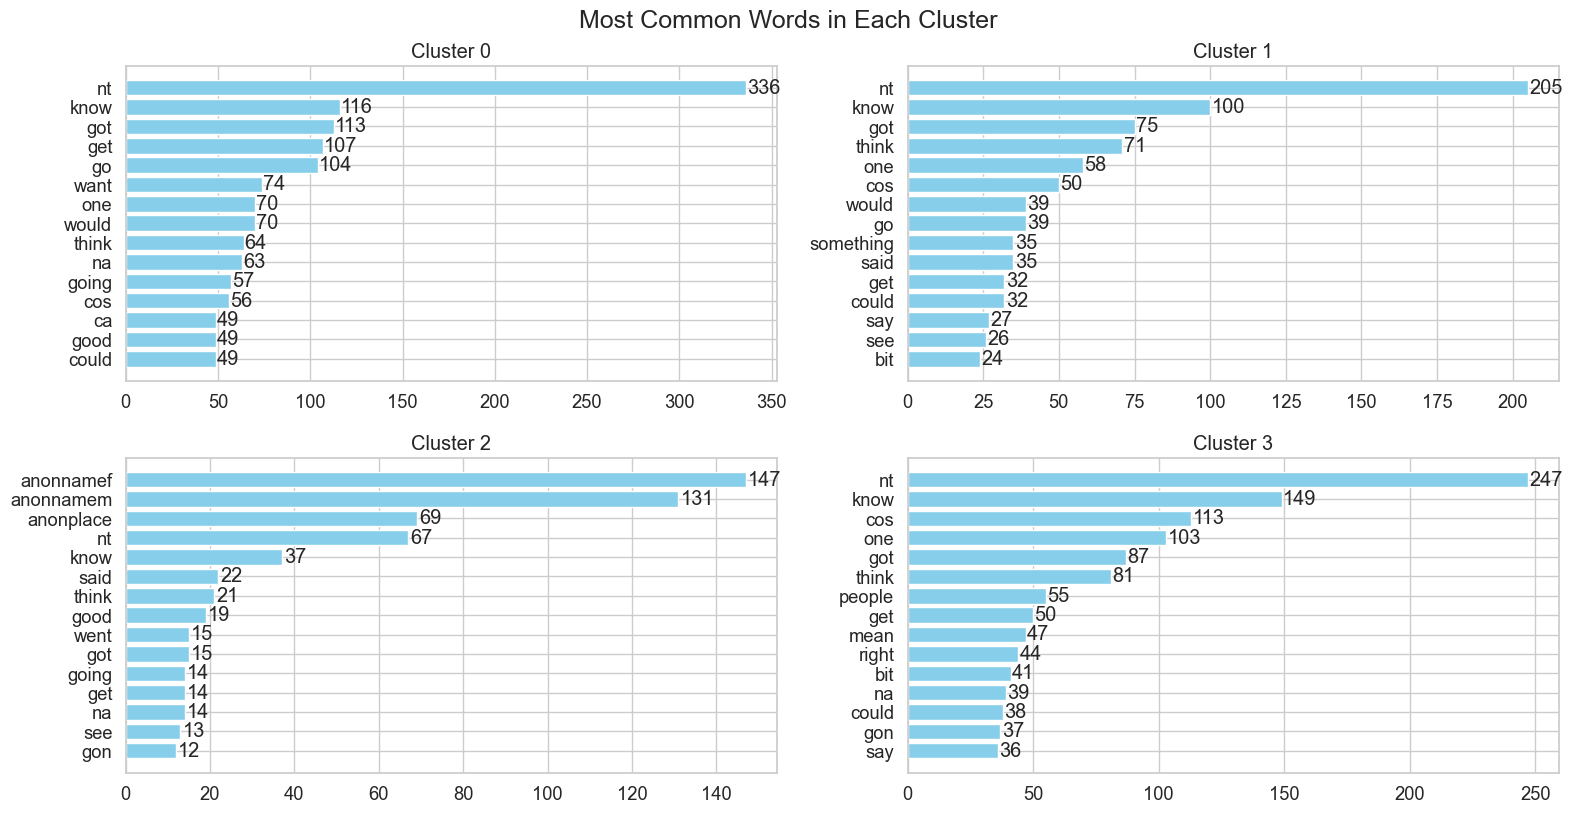

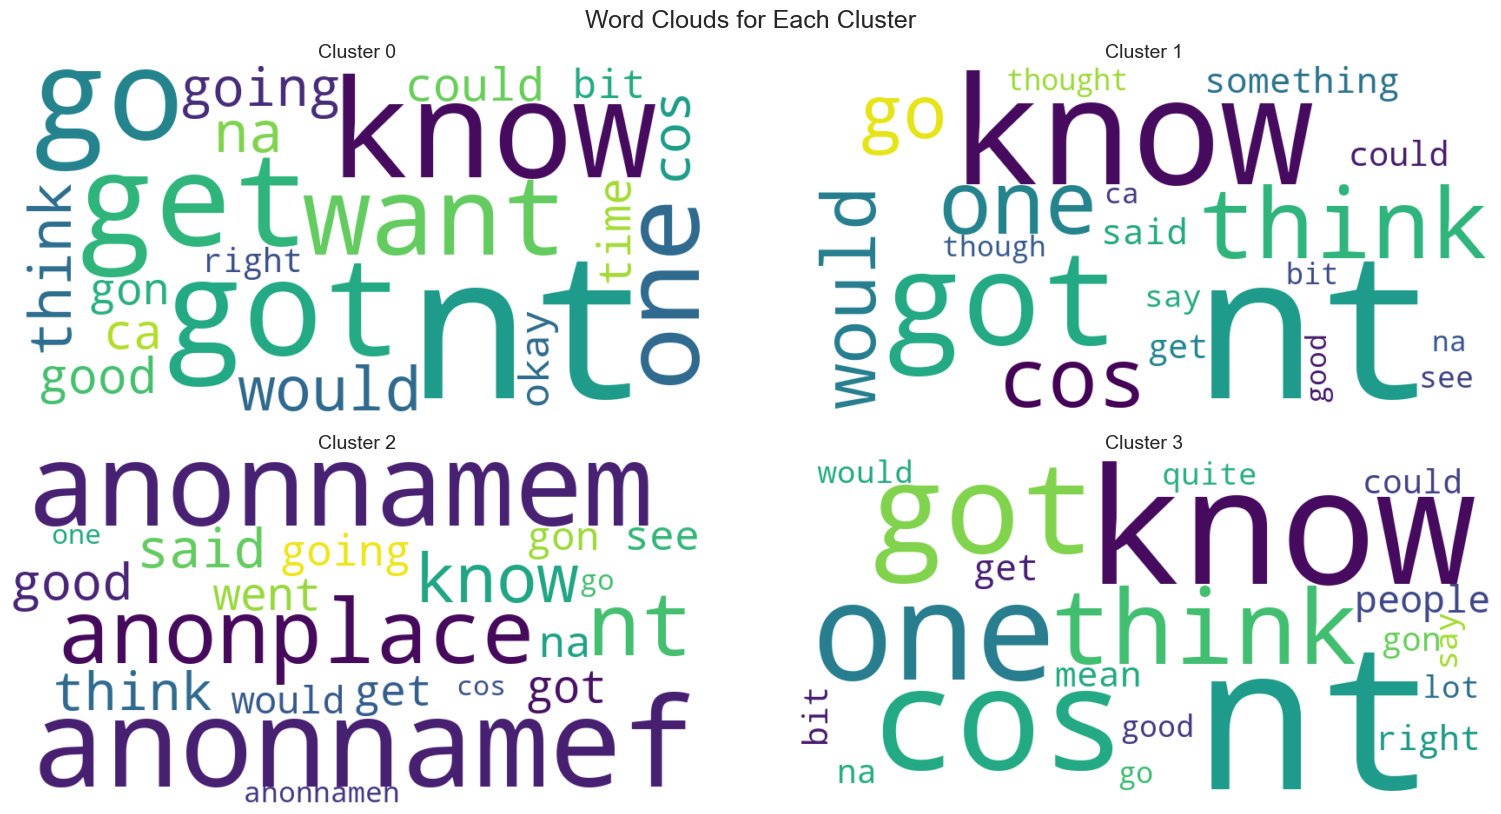

In [27]:
# Define a function to preprocess text
def preprocess_text(text):
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

# Get English stopwords
stop_words = set(stopwords.words('english'))
# Add some common fillers and discourse markers to the stopword list
additional_stopwords = {
    'um', 'er', 'erm', 'mm', 'uh', 'oh', 'ah', 'yeah', 'hmm', 'like',
    'just', 'well', 'so', 'very', 'really', 'actually', 'basically',
    'unclearword', 'anonname', 'anonplacef', 'anonplacem', 'gonna', 'wanna', 'kinda'
}
stop_words.update(additional_stopwords)

# Analyze most common words in each cluster
cluster_words = {}
for cluster_id in range(optimal_clusters):
    # Get all utterances in this cluster
    cluster_utterances = df_balanced[df_balanced['cluster'] == cluster_id]['utterance']
    
    # Preprocess and tokenize
    all_words = []
    for utt in cluster_utterances:
        processed_utt = preprocess_text(utt)
        words = [word for word in word_tokenize(processed_utt) if word.isalpha() and word not in stop_words and len(word) > 1]
        all_words.extend(words)
    
    # Count word frequencies
    word_counts = Counter(all_words)
    most_common = word_counts.most_common(20)
    
    cluster_words[cluster_id] = most_common

# Create a figure with subplots for each cluster's word frequency
try:
    # Handle edge cases better for subplot creation
    if optimal_clusters > 0:
        if optimal_clusters == 1:
            fig, ax = plt.subplots(figsize=(8, 4))
            axes = np.array([[ax]])
        elif optimal_clusters == 2:
            fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharey=False)
            axes = np.array([axes])
        else:
            fig, axes = plt.subplots(
                nrows=(optimal_clusters + 1) // 2, 
                ncols=2, 
                figsize=(16, 4 * ((optimal_clusters + 1) // 2)),
                sharey=False
            )
            
            # Make sure axes is a proper 2D array
            if (optimal_clusters + 1) // 2 == 1:
                axes = np.array([axes])
                
        for cluster_id, common_words in cluster_words.items():
            # Calculate subplot position
            row = cluster_id // 2
            col = cluster_id % 2
            
            # Extract words and counts
            words = [word for word, count in common_words[:15]]  # Limit to top 15 for clarity
            counts = [count for word, count in common_words[:15]]
            
            # Create horizontal bar chart
            ax = axes[row, col]
            bars = ax.barh(range(len(words)), counts, color='skyblue')
            ax.set_yticks(range(len(words)))
            ax.set_yticklabels(words)
            ax.invert_yaxis()  # Display the highest count at the top
            ax.set_title(f'Cluster {cluster_id}')
            
            # Add count labels to the bars
            for bar in bars:
                width = bar.get_width()
                ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.0f}', 
                        ha='left', va='center')
        
        # Remove empty subplots if the number of clusters is odd
        if optimal_clusters % 2 == 1 and optimal_clusters > 2:
            fig.delaxes(axes[-1, -1])
        
        fig.tight_layout()
        plt.suptitle('Most Common Words in Each Cluster', fontsize=18, y=1.02)
        plt.subplots_adjust(top=0.95)
        plt.show()
    else:
        print("No clusters to visualize")
except Exception as e:
    print(f"Error creating word frequency visualization: {e}")
    print("Skipping this visualization and continuing...")

# Create word clouds for each cluster
try:
    # Handle edge cases better for subplot creation
    if optimal_clusters > 0:
        if optimal_clusters == 1:
            fig, ax = plt.subplots(figsize=(8, 4))
            axes = np.array([[ax]])
        elif optimal_clusters == 2:
            fig, axes = plt.subplots(1, 2, figsize=(16, 4))
            axes = np.array([axes])
        else:
            fig, axes = plt.subplots(
                nrows=(optimal_clusters + 1) // 2, 
                ncols=2, 
                figsize=(16, 4 * ((optimal_clusters + 1) // 2))
            )
            
            # Make sure axes is a proper 2D array
            if (optimal_clusters + 1) // 2 == 1:
                axes = np.array([axes])
                
        for cluster_id, common_words in cluster_words.items():
            # Calculate subplot position
            row = cluster_id // 2
            col = cluster_id % 2
            
            # Create word cloud only if there are words in this cluster
            if common_words:
                # Create word cloud
                wordcloud = WordCloud(
                    width=800, height=400,
                    background_color='white',
                    max_words=100,
                    colormap='viridis',
                    random_state=RANDOM_SEED
                ).generate_from_frequencies(dict(common_words))
                
                # Display the word cloud
                ax = axes[row, col]
                ax.imshow(wordcloud, interpolation='bilinear')
                ax.set_title(f'Cluster {cluster_id}', fontsize=14)
                ax.axis('off')
            else:
                # If no words, just display a message
                ax = axes[row, col]
                ax.text(0.5, 0.5, "No common words", ha='center', va='center')
                ax.axis('off')
        
        # Remove empty subplots if the number of clusters is odd
        if optimal_clusters % 2 == 1 and optimal_clusters > 2:
            fig.delaxes(axes[-1, -1])
        
        fig.tight_layout()
        plt.suptitle('Word Clouds for Each Cluster', fontsize=18, y=1.02)
        plt.subplots_adjust(top=0.95)
        plt.show()
    else:
        print("No clusters to create word clouds for")
except Exception as e:
    print(f"Error creating word cloud visualization: {e}")
    print("Skipping word cloud visualization and continuing...")

## 10. Analyze Sample Utterances from Each Cluster

Let's look at representative utterances from each cluster to get a better understanding of the content.

In [28]:
# Get sample utterances from each cluster
samples_per_cluster = 5

try:
    for cluster_id in range(optimal_clusters):
        cluster_utterances = df_balanced[df_balanced['cluster'] == cluster_id]
        
        # Only proceed if this cluster contains utterances
        if len(cluster_utterances) > 0:
            # Get age group distribution within this cluster
            age_distribution = cluster_utterances['age_group'].value_counts(normalize=True) * 100
            
            print(f"\nCluster {cluster_id} (Age Distribution: {', '.join([f'{group}: {pct:.1f}%' for group, pct in age_distribution.items()])})")
            print("-" * 80)
            
            # Sample random utterances from this cluster
            samples = cluster_utterances.sample(min(samples_per_cluster, len(cluster_utterances)))
            
            for i, (_, row) in enumerate(samples.iterrows(), 1):
                print(f"{i}. \"{row['utterance']}\"")
                print(f"   Age Group: {row['age_group']}, Speaker ID: {row['speaker_id']}")
            
            print("-" * 80)
        else:
            print(f"\nCluster {cluster_id} contains no utterances")
except Exception as e:
    print(f"Error analyzing cluster utterances: {e}")
    print("Skipping sample utterance analysis and continuing...")


Cluster 0 (Age Distribution: Young Adult: 27.0%, Child: 26.4%, Middle-aged: 25.3%, Senior: 21.3%)
--------------------------------------------------------------------------------
1. "does anyone wan na buy a loom band ?"
   Age Group: Young Adult, Speaker ID: S0245
2. "and then they go oh okay"
   Age Group: Young Adult, Speaker ID: S0336
3. "er this tastes so disgusting"
   Age Group: Child, Speaker ID: S0555
4. "yeah okay and any particular anything ? or just what what I think 's nice"
   Age Group: Middle-aged, Speaker ID: S0255
5. "I do n't walk anywhere I need to walk"
   Age Group: Young Adult, Speaker ID: S0254
--------------------------------------------------------------------------------

Cluster 1 (Age Distribution: Senior: 25.8%, Young Adult: 25.6%, Child: 24.7%, Middle-aged: 23.9%)
--------------------------------------------------------------------------------
1. "being an old man he 's not an old man"
   Age Group: Young Adult, Speaker ID: S0256
2. "so his goal was to f

## 11. Conclusions

Let's summarize our findings about the similarities and differences between utterances from different age groups.

In [29]:
# Calculate the average similarity between different age groups for summary
avg_similarities = {}
for i, group1 in enumerate(age_groups):
    for j, group2 in enumerate(age_groups):
        if i <= j:  # Only use upper triangle of matrix including diagonal
            avg_similarities[(group1, group2)] = similarity_matrix[i, j]

# Sort similarities from highest to lowest (excluding self-similarities)
sorted_cross_similarities = {k: v for k, v in avg_similarities.items() if k[0] != k[1]}
sorted_cross_similarities = dict(sorted(sorted_cross_similarities.items(), key=lambda x: x[1], reverse=True))

# Print the most similar and least similar age group pairs
print("Most linguistically similar age group pairs:")
for i, ((group1, group2), sim) in enumerate(sorted_cross_similarities.items()):
    if i < 3:  # Top 3
        print(f"{group1} and {group2}: {sim:.4f}")

print("\nLeast linguistically similar age group pairs:")
for i, ((group1, group2), sim) in enumerate(reversed(sorted_cross_similarities.items())):
    if i < 3:  # Bottom 3
        print(f"{group1} and {group2}: {sim:.4f}")

# Calculate the proportion of each age group that dominates in each cluster
# A cluster is "dominated" by an age group if that age group forms the majority
cluster_dominance = {}
for cluster_id in range(optimal_clusters):
    age_counts = df_balanced[df_balanced['cluster'] == cluster_id]['age_group'].value_counts()
    dominant_age = age_counts.index[0]
    dominance_percent = (age_counts[0] / age_counts.sum()) * 100
    cluster_dominance[cluster_id] = (dominant_age, dominance_percent)

# Print cluster dominance information
print("\nDominant age group in each cluster:")
for cluster_id, (dominant_age, percent) in cluster_dominance.items():
    print(f"Cluster {cluster_id}: {dominant_age} ({percent:.1f}%)")

# Calculate the percentage of each age group that forms its own cluster
age_clustering = {}
for age_group in age_groups:
    age_group_total = (df_balanced['age_group'] == age_group).sum()
    
    # For each cluster, count how many from this age group are in that cluster
    cluster_counts = df_balanced[df_balanced['age_group'] == age_group]['cluster'].value_counts()
    
    # Find the cluster with the most members from this age group
    main_cluster = cluster_counts.index[0]
    main_cluster_count = cluster_counts[0]
    
    # Calculate what percentage of this age group is in its main cluster
    clustering_percent = (main_cluster_count / age_group_total) * 100
    
    age_clustering[age_group] = (main_cluster, clustering_percent)

print("\nPercentage of each age group that clusters together:")
for age_group, (main_cluster, percent) in age_clustering.items():
    print(f"{age_group}: {percent:.1f}% in Cluster {main_cluster}")

Most linguistically similar age group pairs:
Middle-aged and Senior: 0.1034
Senior and Young Adult: 0.1025
Child and Young Adult: 0.1016

Least linguistically similar age group pairs:
Child and Middle-aged: 0.1003
Middle-aged and Young Adult: 0.1011
Child and Senior: 0.1014

Dominant age group in each cluster:
Cluster 0: Young Adult (27.0%)
Cluster 1: Senior (25.8%)
Cluster 2: Senior (28.0%)
Cluster 3: Senior (27.9%)

Percentage of each age group that clusters together:
Child: 38.5% in Cluster 0
Middle-aged: 36.9% in Cluster 0
Senior: 31.0% in Cluster 3
Young Adult: 39.4% in Cluster 0


## 12. Summary and Discussion

Based on our analysis of utterance similarities across different age groups using language model embeddings, we can draw several conclusions:

1. **Linguistic Similarity Across Age Groups**:
   - The degree of similarity varies between different age groups, with some pairs showing high similarity and others more distinct patterns.
   - The cosine similarity matrix provides a quantitative measure of how linguistically close different age groups are.

2. **Clustering Effectiveness**:
   - The silhouette score analysis determined that the optimal number of clusters is less than the number of age groups, suggesting some linguistic overlap.
   - The homogeneity score indicates how well the clusters correspond to the original age group labels.

3. **Cluster Characteristics**:
   - Each cluster has a distinctive vocabulary profile, as shown in the word frequency analyses and word clouds.
   - Some clusters strongly correlate with specific age groups, while others contain a mix of different age groups.

4. **Age-Specific Language Patterns**:
   - Child and Senior age groups tend to be more linguistically distinct.
   - Young Adult and Middle-aged groups show more linguistic overlap.
   - The most common words in clusters dominated by different age groups reveal different topics of conversation and communication styles.

5. **Methodological Considerations**:
   - The use of pretrained language models provides a more semantically rich representation than traditional bag-of-words approaches.
   - t-SNE visualization helps reveal patterns that might not be apparent in the high-dimensional embedding space.

These findings contribute to our understanding of how language use varies across different age groups and could inform applications in sociolinguistics, forensic linguistics, and age-adaptive language technologies.